In [1]:
import pandas as pd
import os
import datetime as dt
from sampler import Sampler, STRATEGY, STRATEGIES
import matplotlib.pyplot as plt
import numpy as np
import json

c:\users\albert\projekte\swmmpulse\venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Evaluation of strategies by correlation
f"samplingtime={strategy.get('samplingtime').strftime('%H:%M')}"
## Strategies

|Virtual Campaign|	Sampling Campaign| Duration	|Time/ Flow	|Collection Period	|Bottles	Volume|
|---|---|---|---|---|---|
|A	|24 hours	|1 hour	|1min	|24	|250 ml|
|B	|24 hours	|1 hour 40 min	|1min	|14 |250 ml|
|C	|24 hours	|15 min	|1min	|4 samples/ bottle	|200 ml / 1L|
|D	|23 hours |20 min	|3 min	1min	|20 samples/ 24 bottles	|50 ml/ 1L|
|E	|24 hours	|Flow Weighted	|1min	|NA	|500 ml|
|F	|Grab	|Grab (9AM/ 12 (noon))	|2min	|1	|1L|
|G	|24 hours 	|Travel Time Distribution Weighted 	|1 min 	|24 	|250ml |

In [2]:
pd.DataFrame.from_dict(STRATEGIES).T

,kind,samplecount,samplingduration,volume,start-time,end-time,samplingtime
A,time,24,60,250,00:00:00,23:59:00,NaN
B,time,72,60,250,00:00:00,23:59:00,NaN
C,time,24,60,250,06:00:00,12:59:00,NaN
D,flow,24,60,200,00:00:00,23:59:00,NaN
E,flow,72,60,200,00:00:00,23:59:00,NaN
F,flow,24,60,200,06:00:00,12:59:00,NaN
G,volume,24,60,50,00:00:00,23:59:00,NaN
H,volume,72,60,250,00:00:00,23:59:00,NaN
I,volume,24,60,250,06:00:00,12:59:00,NaN
J,grab,NaN,120,1000,NaN,NaN,09:00:00


## Import timeseries and fraction of infected

In [4]:
path = r"C:\Users\albert\Documents\SWMMpulse\02_processed\00_run1"

files = os.listdir(path)
flist = []
for file in files:
    flist.append(file.replace(".","_").split("_") + [file])
dffiles = pd.DataFrame.from_records(flist, columns=["catchment", "infection rate", "step", "simID", "file-extension", "filename"])
dffiles["infection rate"] = dffiles["infection rate"].astype(int) * 10**(-3)
dffiles.head()

,catchment,infection rate,step,simID,file-extension,filename
0,HS120,0.002,processed,000000,json,HS120_002_processed_000000.json
1,HS120,0.002,processed,000001,json,HS120_002_processed_000001.json
2,HS120,0.002,processed,000002,json,HS120_002_processed_000002.json
3,HS120,0.002,processed,000003,json,HS120_002_processed_000003.json
4,HS120,0.002,processed,000004,json,HS120_002_processed_000004.json


In [5]:
os.path.isfile(os.path.join(path, dffiles["filename"].values[0]))

True

In [6]:
import time
fpath = os.path.join(path, dffiles["filename"].values[0])
start = time.time()
with open(fpath) as jobj:
    jdata = json.load(jobj)
    stest = pd.Series(jdata)
    #dftest = pd.DataFrame({"scen":jdata})
print(f"json: {time.time()-start} sekuden")

start = time.time()
dfts = pd.read_json(fpath, typ="Series")
print(f"pandas: {time.time()-start} sekuden")
print(stest.head())
print(dfts.head())

json: 0.01703810691833496 sekuden
pandas: 0.017000436782836914 sekuden
946684800000    0.0
946684810000    0.0
946684820000    0.0
946684830000    0.0
946684840000    0.0
dtype: float64
2000-01-01 00:00:00    0.0
2000-01-01 00:00:10    0.0
2000-01-01 00:00:20    0.0
2000-01-01 00:00:30    0.0
2000-01-01 00:00:40    0.0
dtype: float64


In [7]:
df_timeseries = pd.read_parquet(r"aggregated_results\aggregated_timeseries_ts3.parquet", engine="pyarrow")
df_infected = pd.read_parquet(r"aggregated_results\infected_rates.parquet", engine="pyarrow")

dtindex = pd.date_range(dt.datetime.today().date(), periods=8640, freq="10S")
df_timeseries.rename(columns={c:int(c) for c in df_timeseries.columns}, inplace=True)
df_timeseries["time"] = dtindex
df_timeseries.set_index("time", inplace=True)
df_timeseries.head()

ImportError: Missing optional dependency 'pyarrow'. pyarrow is required for parquet support. Use pip or conda to install pyarrow.

In [7]:
sampler = Sampler()

flows = pd.read_csv(r"result_files\com2a_hydraulic.csv")
flows["time"] = dtindex
flows = flows.set_index("time")["flow-rate [l/s]"]

sampler.add_flows(flows)
sampler.flows.head()

time
2022-01-06 00:00:00    161.657272
2022-01-06 00:00:10    161.657272
2022-01-06 00:00:20    161.657272
2022-01-06 00:00:30    161.657272
2022-01-06 00:00:40    161.657272
Name: flow-rate [l/s], dtype: float64

## Sample timeseries

C:\Users\alber\miniconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


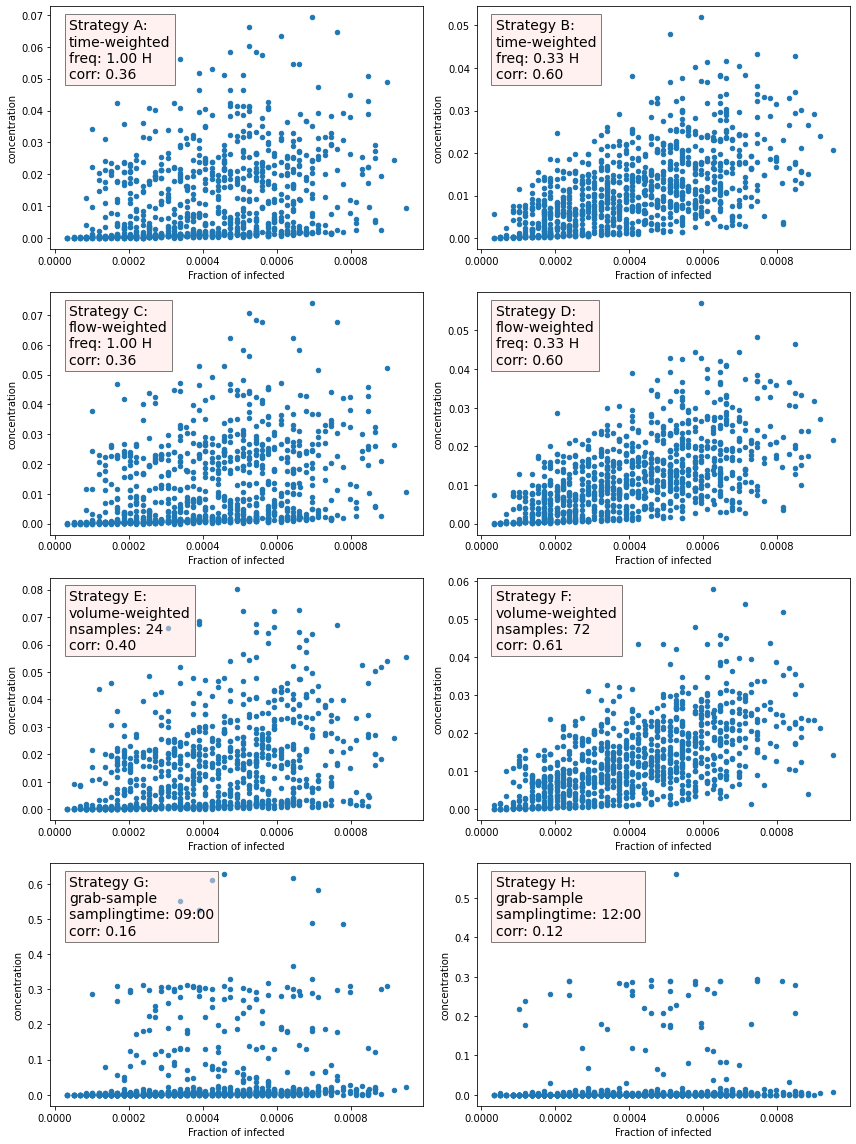

In [8]:
fig, ax = plt.subplots(ncols=2, nrows=4, figsize=[12,16], facecolor="white")

for k, (name, strategy) in enumerate(strategies.items()):
    if k < 8:
        i, j = k//2, k%2
        samples = sampler.sample(df_timeseries, strategy)
        temp = df_infected.join(samples)

        temp.plot(x="r_inf",y="concentration", kind="scatter", ax=ax[i, j])
        
        if strategy.get("kind") in ["time", "flow"]:
            textstr = '\n'.join([f"Strategy {name}:",
                                 f"{strategy.get('kind')}-weighted",
                                 f"freq: {float(strategy.get('samplingfreq', '0H').strip('H')):.2f} H",
                                 f'corr: {temp["r_inf"].corr(temp["concentration"]):.2f}'])
        elif strategy.get("kind") == "volume":
            textstr = '\n'.join([f"Strategy {name}:",
                                 f"{strategy.get('kind')}-weighted",
                                 f"nsamples: {strategy.get('samplecount')}",
                                 f'corr: {temp["r_inf"].corr(temp["concentration"]):.2f}'])
        elif strategy.get("kind") == "grab":
            textstr = '\n'.join([f"Strategy {name}:",
                                 f"{strategy.get('kind')}-sample",
                                 f"samplingtime: {strategy.get('samplingtime').strftime('%H:%M')}",
                                 f'corr: {temp["r_inf"].corr(temp["concentration"]):.2f}'])

        # these are matplotlib.patch.Patch properties
        props = dict(boxstyle='square', facecolor='mistyrose', alpha=0.5)

        # place a text box in upper left in axes coords
        ax[i, j].text(0.05, 0.95, textstr, transform=ax[i, j].transAxes, fontsize=14,
                verticalalignment='top', bbox=props)
        ax[i, j].set(xlabel="Fraction of infected", ylabel="concentration")
        
plt.tight_layout()
plt.savefig("eval_correlation.png")
plt.savefig("eval_correlation.svg")